In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import scanpy as sc
import igraph


import time
from pathlib import Path
import torch
import Concord as ccd
import scFates as scf 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/anaconda3/envs/Concord/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import data

# ../.../..._ZJ.h5ad merges the cell types in the intestine_dev dataset: MSC, Epithelial, Endothelial, Mesenchymal.
adata = sc.read_h5ad('../data/intestine_dev/intestine_Huycke_ZJ.h5ad')
adata_raw = adata.copy()

In [4]:
proj_name = "Huycke_benchmarking_cell_cycle"
save_dir = f"../save/{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"

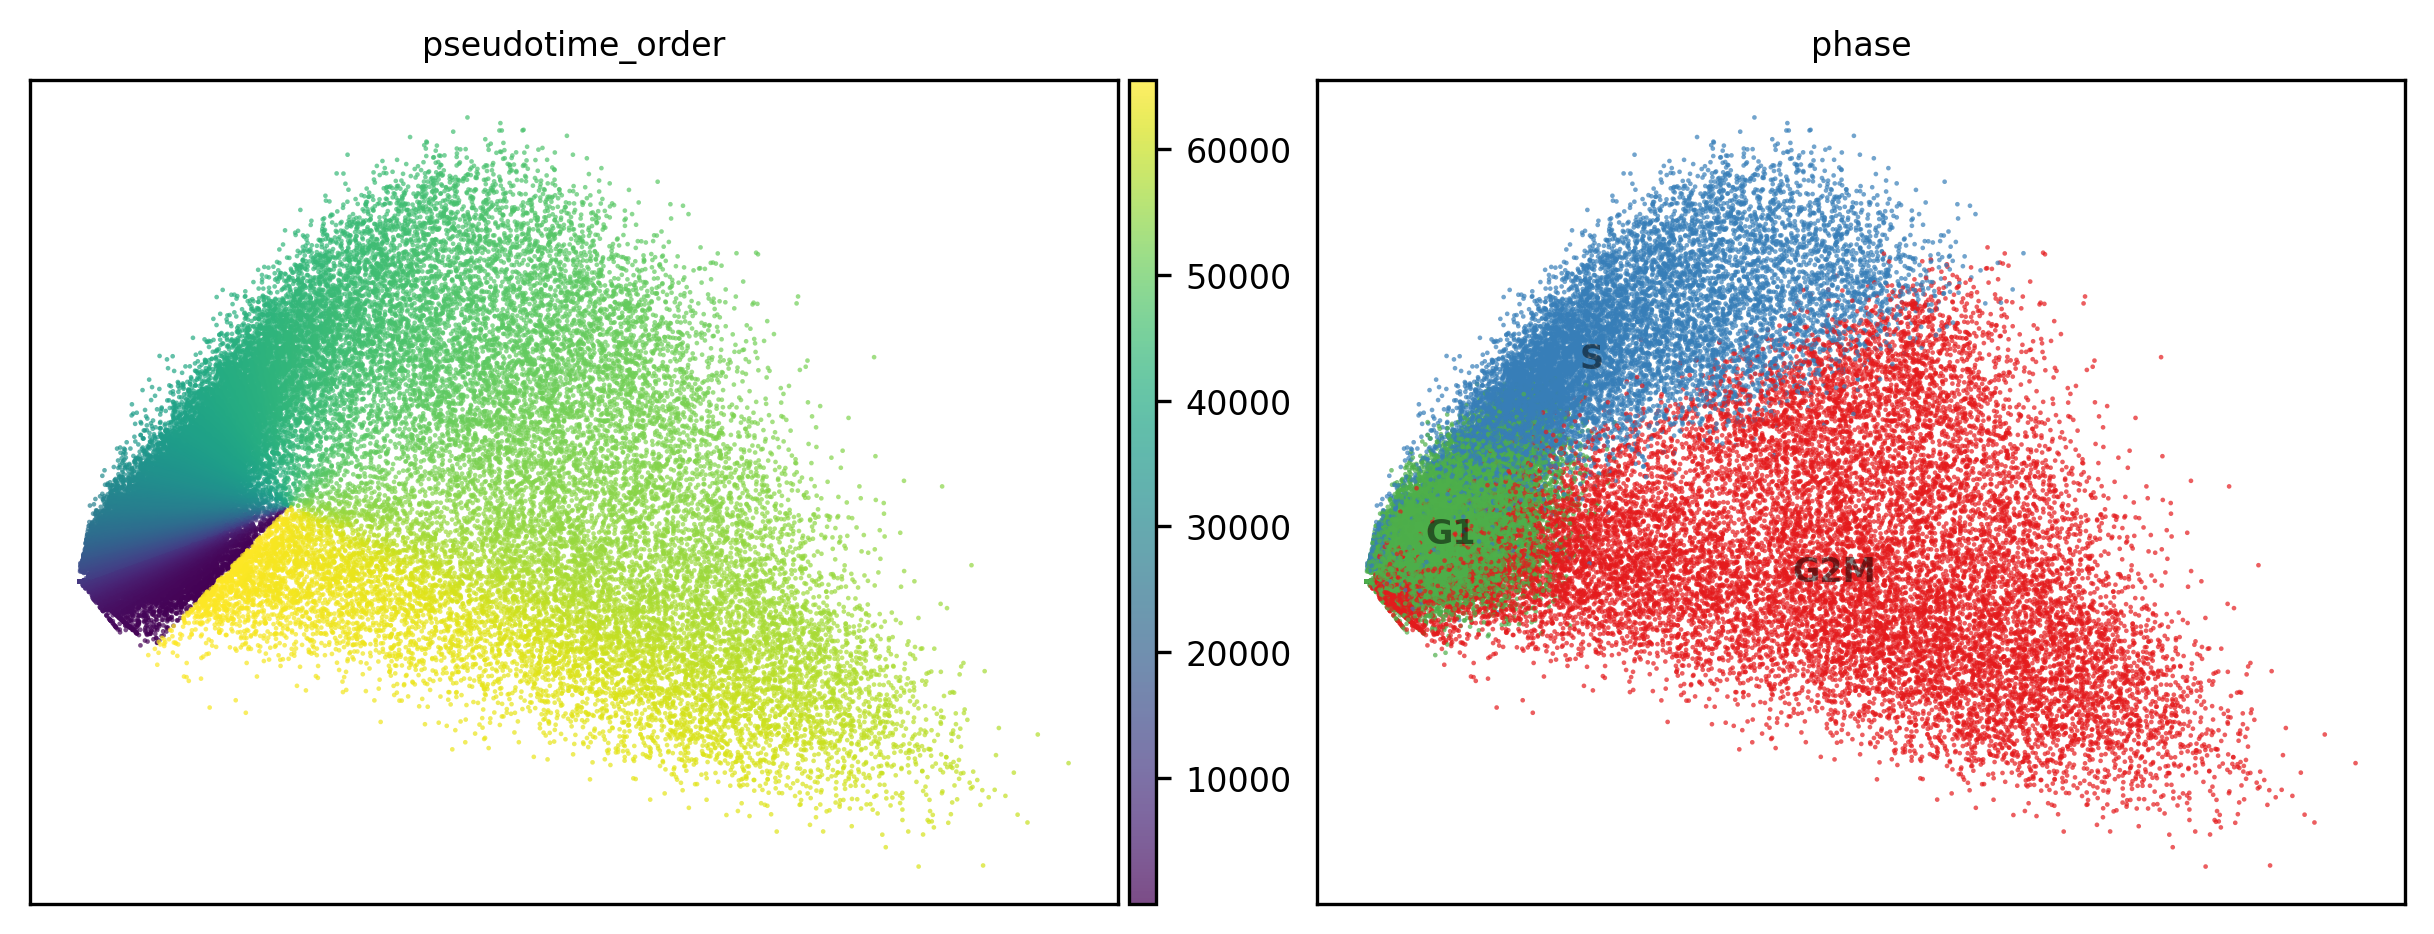

In [7]:
# color the cells by the cell cycle phase and pseudotime order (based on polar coordinates)
ccd.pl.plot_embedding(adata, color_by=['pseudotime_order','phase'], basis='cc_PCA', alpha=0.7,
                      point_size = 5,
                      figsize=(8, 3), ncols=2)

In [ ]:
num_nodes = 30

scf.tl.circle(adata,Nodes=num_nodes,use_rep="cc_PCA",ndims_rep=2)

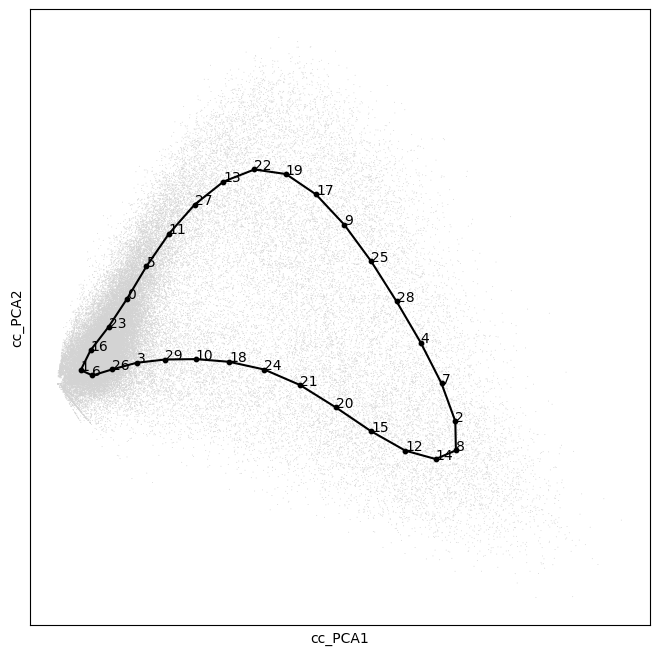

In [24]:
proj = adata.uns["epg"]["NodePositions"]

B = adata.uns["graph"]['B']
basis = 'cc_PCA'

# generate a fig and ax
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sc.pl.embedding(
        adata, color=None, basis=basis, ax=ax, show=False,
    )

al = np.array(
    igraph.Graph.Adjacency((B > 0).tolist(), mode="undirected").get_edgelist()
)
segs = al.tolist()
vertices = proj.tolist()
lines = [[tuple(vertices[j]) for j in i] for i in segs]
lc = matplotlib.collections.LineCollection(
    lines, colors="k", rasterized=True
)
ax.add_collection(lc)

ax.scatter(
    proj[:, 0], proj[:, 1], s=10, c="k",rasterized=True
)

for i, txt in enumerate(range(num_nodes)):
    ax.annotate(txt, (proj[i, 0], proj[i, 1]))

plt.show()

In [15]:
scf.tl.convert_to_soft(adata,sigma=1,lam=100)

Converting R into soft assignment matrix
    finished (0:00:00) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


In [16]:
def geodesic_distance(coords, path):
    geo_dist = 0
    for i in range(len(path) - 1):
        geo_dist += np.linalg.norm(coords[path[i]] - coords[path[i + 1]])
    return geo_dist 

def euclidean_distance(coords, path):
    return np.linalg.norm(coords[path[0]] - coords[path[-1]])


In [17]:
points = adata.uns['epg']['NodePositions'].copy()
adj_matrix = adata.uns['graph']['B'].copy()

import networkx as nx

# Create a graph from the adjacency matrix
G = nx.from_numpy_matrix(adj_matrix)

# Specify the root node
root_node = 26
# Perform DFS
dfs_traversal = list(nx.dfs_edges(G, source=root_node))
dfs_nodes = list(nx.dfs_tree(G, source=root_node))

# concatenate two copies of the points and dfs_nodes
points_dup = np.concatenate((points, points), axis=0)
dfs_nodes_dup = np.concatenate((dfs_nodes, dfs_nodes), axis=0)

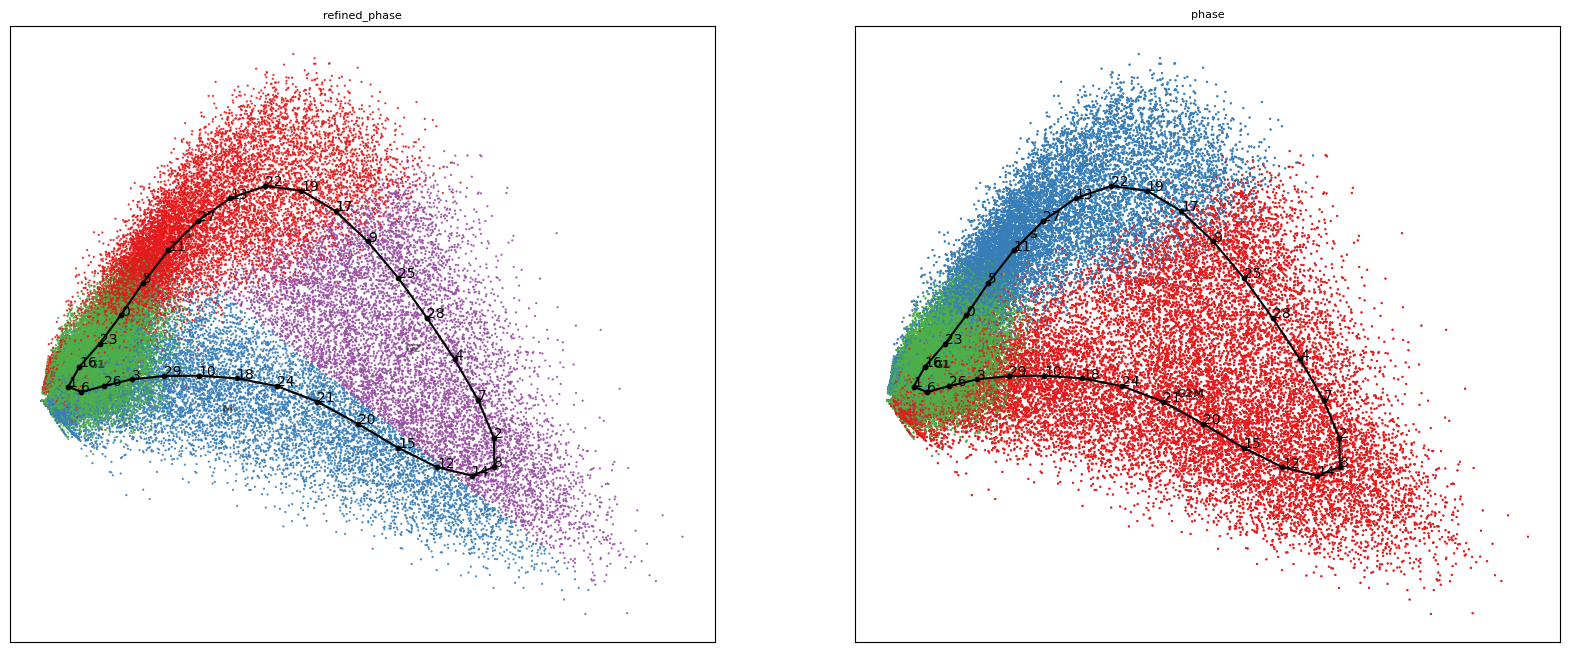

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs = axs.flatten()
ccd.pl.plot_embedding(adata, basis=basis, color_by=['refined_phase'], ax=axs[0])

# plot the nodes and color them based on their curvature values
# plot the principal curve above the embedding
ccd.pl.plot_embedding(adata, basis=basis, color_by=['phase'], ax=axs[1])

axs[0].scatter(points[:, 0], points[:, 1], s=10, c="k",rasterized=True)
for i, idx in enumerate(range(num_nodes)):
    axs[0].annotate(idx, (points[i, 0], points[i, 1]))
al = np.array(
    igraph.Graph.Adjacency((adj_matrix > 0).tolist(), mode="undirected").get_edgelist()
)
segs = al.tolist()
vertices = points.tolist()
lines = [[tuple(vertices[j]) for j in i] for i in segs]
lc = matplotlib.collections.LineCollection(
    lines, colors="k", rasterized=True
)
axs[0].add_collection(lc)

# plot the principal curve above the embedding
ccd.pl.plot_embedding(adata, basis=basis, color_by=['phase'], ax=axs[1])

axs[1].scatter(points[:, 0], points[:, 1], s=10, c="k",rasterized=True)
for i, idx in enumerate(range(num_nodes)):
    axs[1].annotate(idx, (points[i, 0], points[i, 1]))
al = np.array(
    igraph.Graph.Adjacency((adj_matrix > 0).tolist(), mode="undirected").get_edgelist()
)
segs = al.tolist()
vertices = points.tolist()
lines = [[tuple(vertices[j]) for j in i] for i in segs]
lc = matplotlib.collections.LineCollection(
    lines, colors="k", rasterized=True
)
axs[1].add_collection(lc)


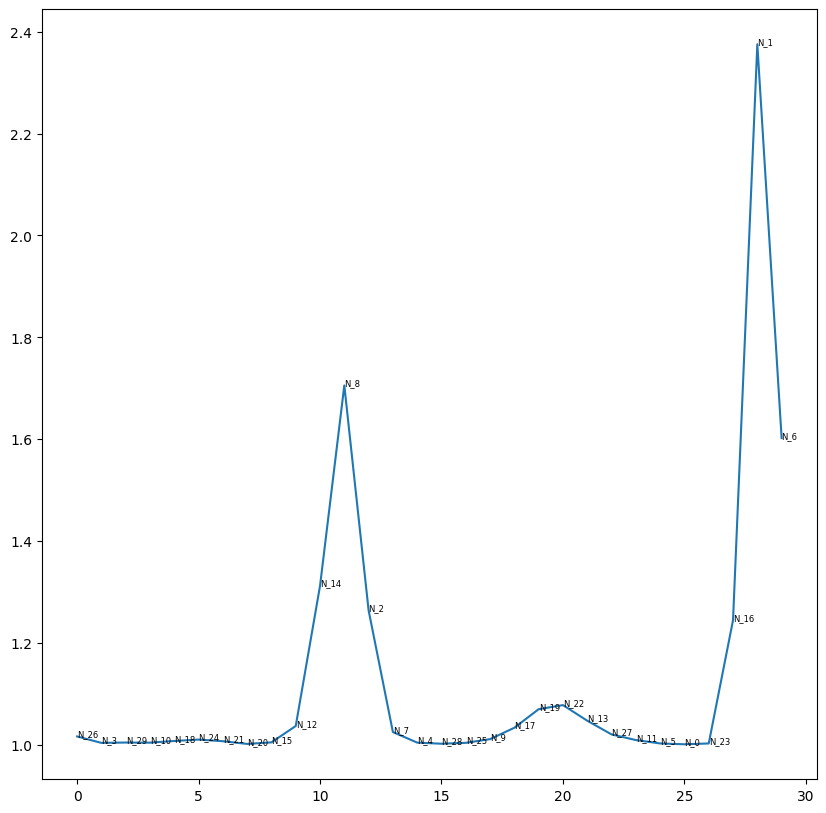

In [26]:
# create a np.array to store the node indices and its corresponding curvatures
offset = 2
curvature = np.zeros((num_nodes, 2))
curvature[:, 0] = dfs_nodes

for i in range(offset,len(dfs_nodes) + offset):

    geo_dis = geodesic_distance(points_dup, dfs_nodes_dup[i-offset:i+offset+1])
    euc_dis = euclidean_distance(points_dup, dfs_nodes_dup[i-offset:i+offset+1])
    cur = geo_dis / euc_dis
    if i < len(dfs_nodes):
        curvature[i, 1] = cur
    else:
        curvature[i-len(dfs_nodes), 1] = cur

# plot the curvature along the path, and label the nodes with their indices
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.plot(curvature[:, 1])
for i in range(num_nodes):
    plt.annotate(f'N_{int(curvature[i, 0])}', (i, curvature[i, 1]), fontsize=6)


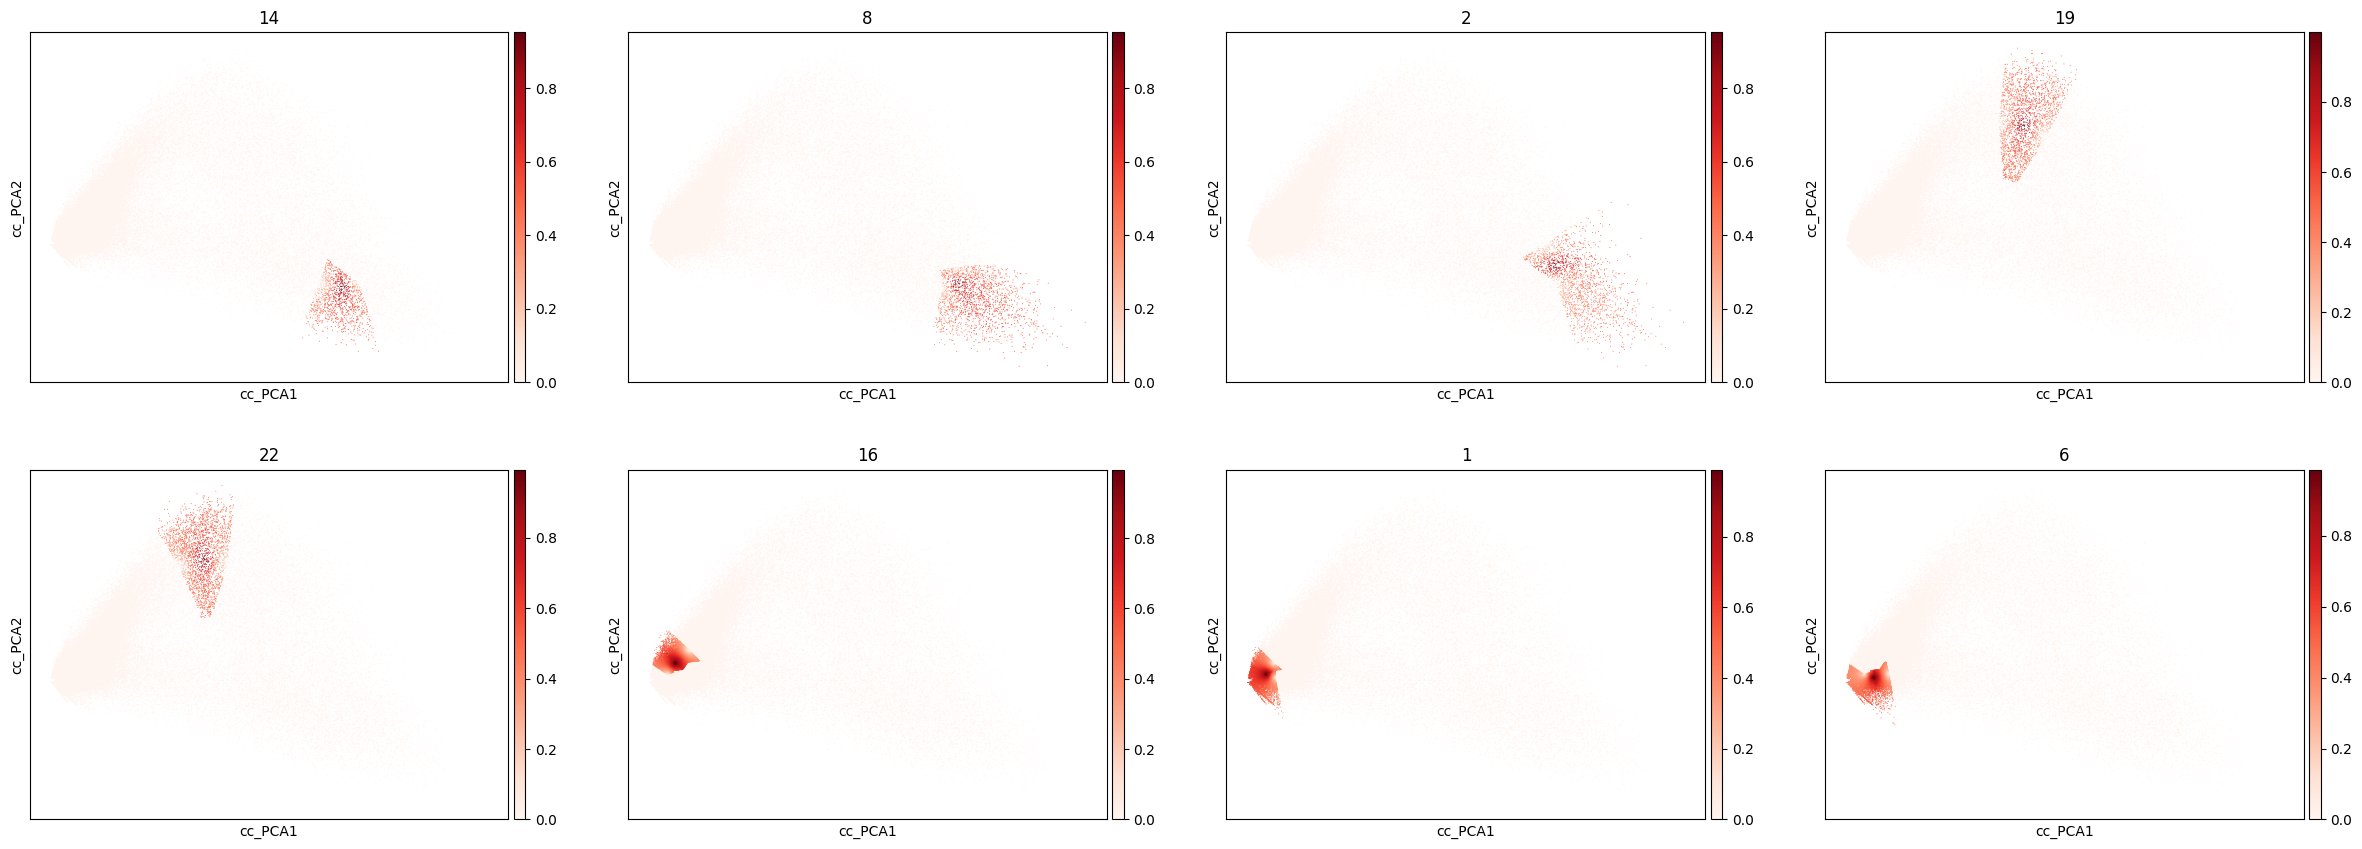

In [28]:
sc.pl.embedding(sc.AnnData(adata.obsm["X_R"],obsm=adata.obsm), basis = 'cc_PCA', color=['14','8','2','19','22','16','1','6'],cmap="Reds")


In [29]:
adata.obsm["X_R"].shape

(65468, 30)

In [63]:
print(adata.obsm["X_R"][0,:])
adata.obsm["X_R"][0,:].sum()

[0.         0.         0.48682474 0.         0.         0.
 0.         0.         0.51317526 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


0.9999999999999999

In [51]:
# detect the peaks of the curvature values
import scipy.signal as signal
peaks, _ = signal.find_peaks(curvature[:, 1], threshold=0.005)
print(peaks)

edges = []

if len(peaks) > 0:
    edges.append(dfs_nodes[:peaks[0]])
for i in range(len(peaks) - 1):
    edges.append(dfs_nodes[peaks[i]:peaks[i+1]])
if len(peaks) > 0:
    edges.append(dfs_nodes[peaks[-1]:])    

# merge the latest edge with the first edge
if len(peaks) > 0:
    edges[0] = np.concatenate((edges[0], edges[-1]))
    edges.pop(-1)
print(edges)

# store the edge in a dictionary
edge_dict = {}
for i, edge in enumerate(edges):
    edge_dict[i] = edge
print(edge_dict)


[11 20 28]
[array([26,  3, 29, 10, 18, 24, 21, 20, 15, 12, 14,  1,  6]), [8, 2, 7, 4, 28, 25, 9, 17, 19], [22, 13, 27, 11, 5, 0, 23, 16]]
{0: array([26,  3, 29, 10, 18, 24, 21, 20, 15, 12, 14,  1,  6]), 1: [8, 2, 7, 4, 28, 25, 9, 17, 19], 2: [22, 13, 27, 11, 5, 0, 23, 16]}


In [70]:
# create a obs in adata to store the edge information
adata.obs["edges_phase"] = "None"

# for each cell:
for i in range(adata.shape[0]):
    prob = adata.obsm["X_R"][i,:]
    # find the index of the maximum probability 
    node_idx = np.argmax(prob)
    # according to the node index, find the edge that the cell belongs to and assign the edge information to the cell
    for key, edge in edge_dict.items():
        if node_idx in edge:
            adata.obs["edges_phase"][i] = key
            break
     

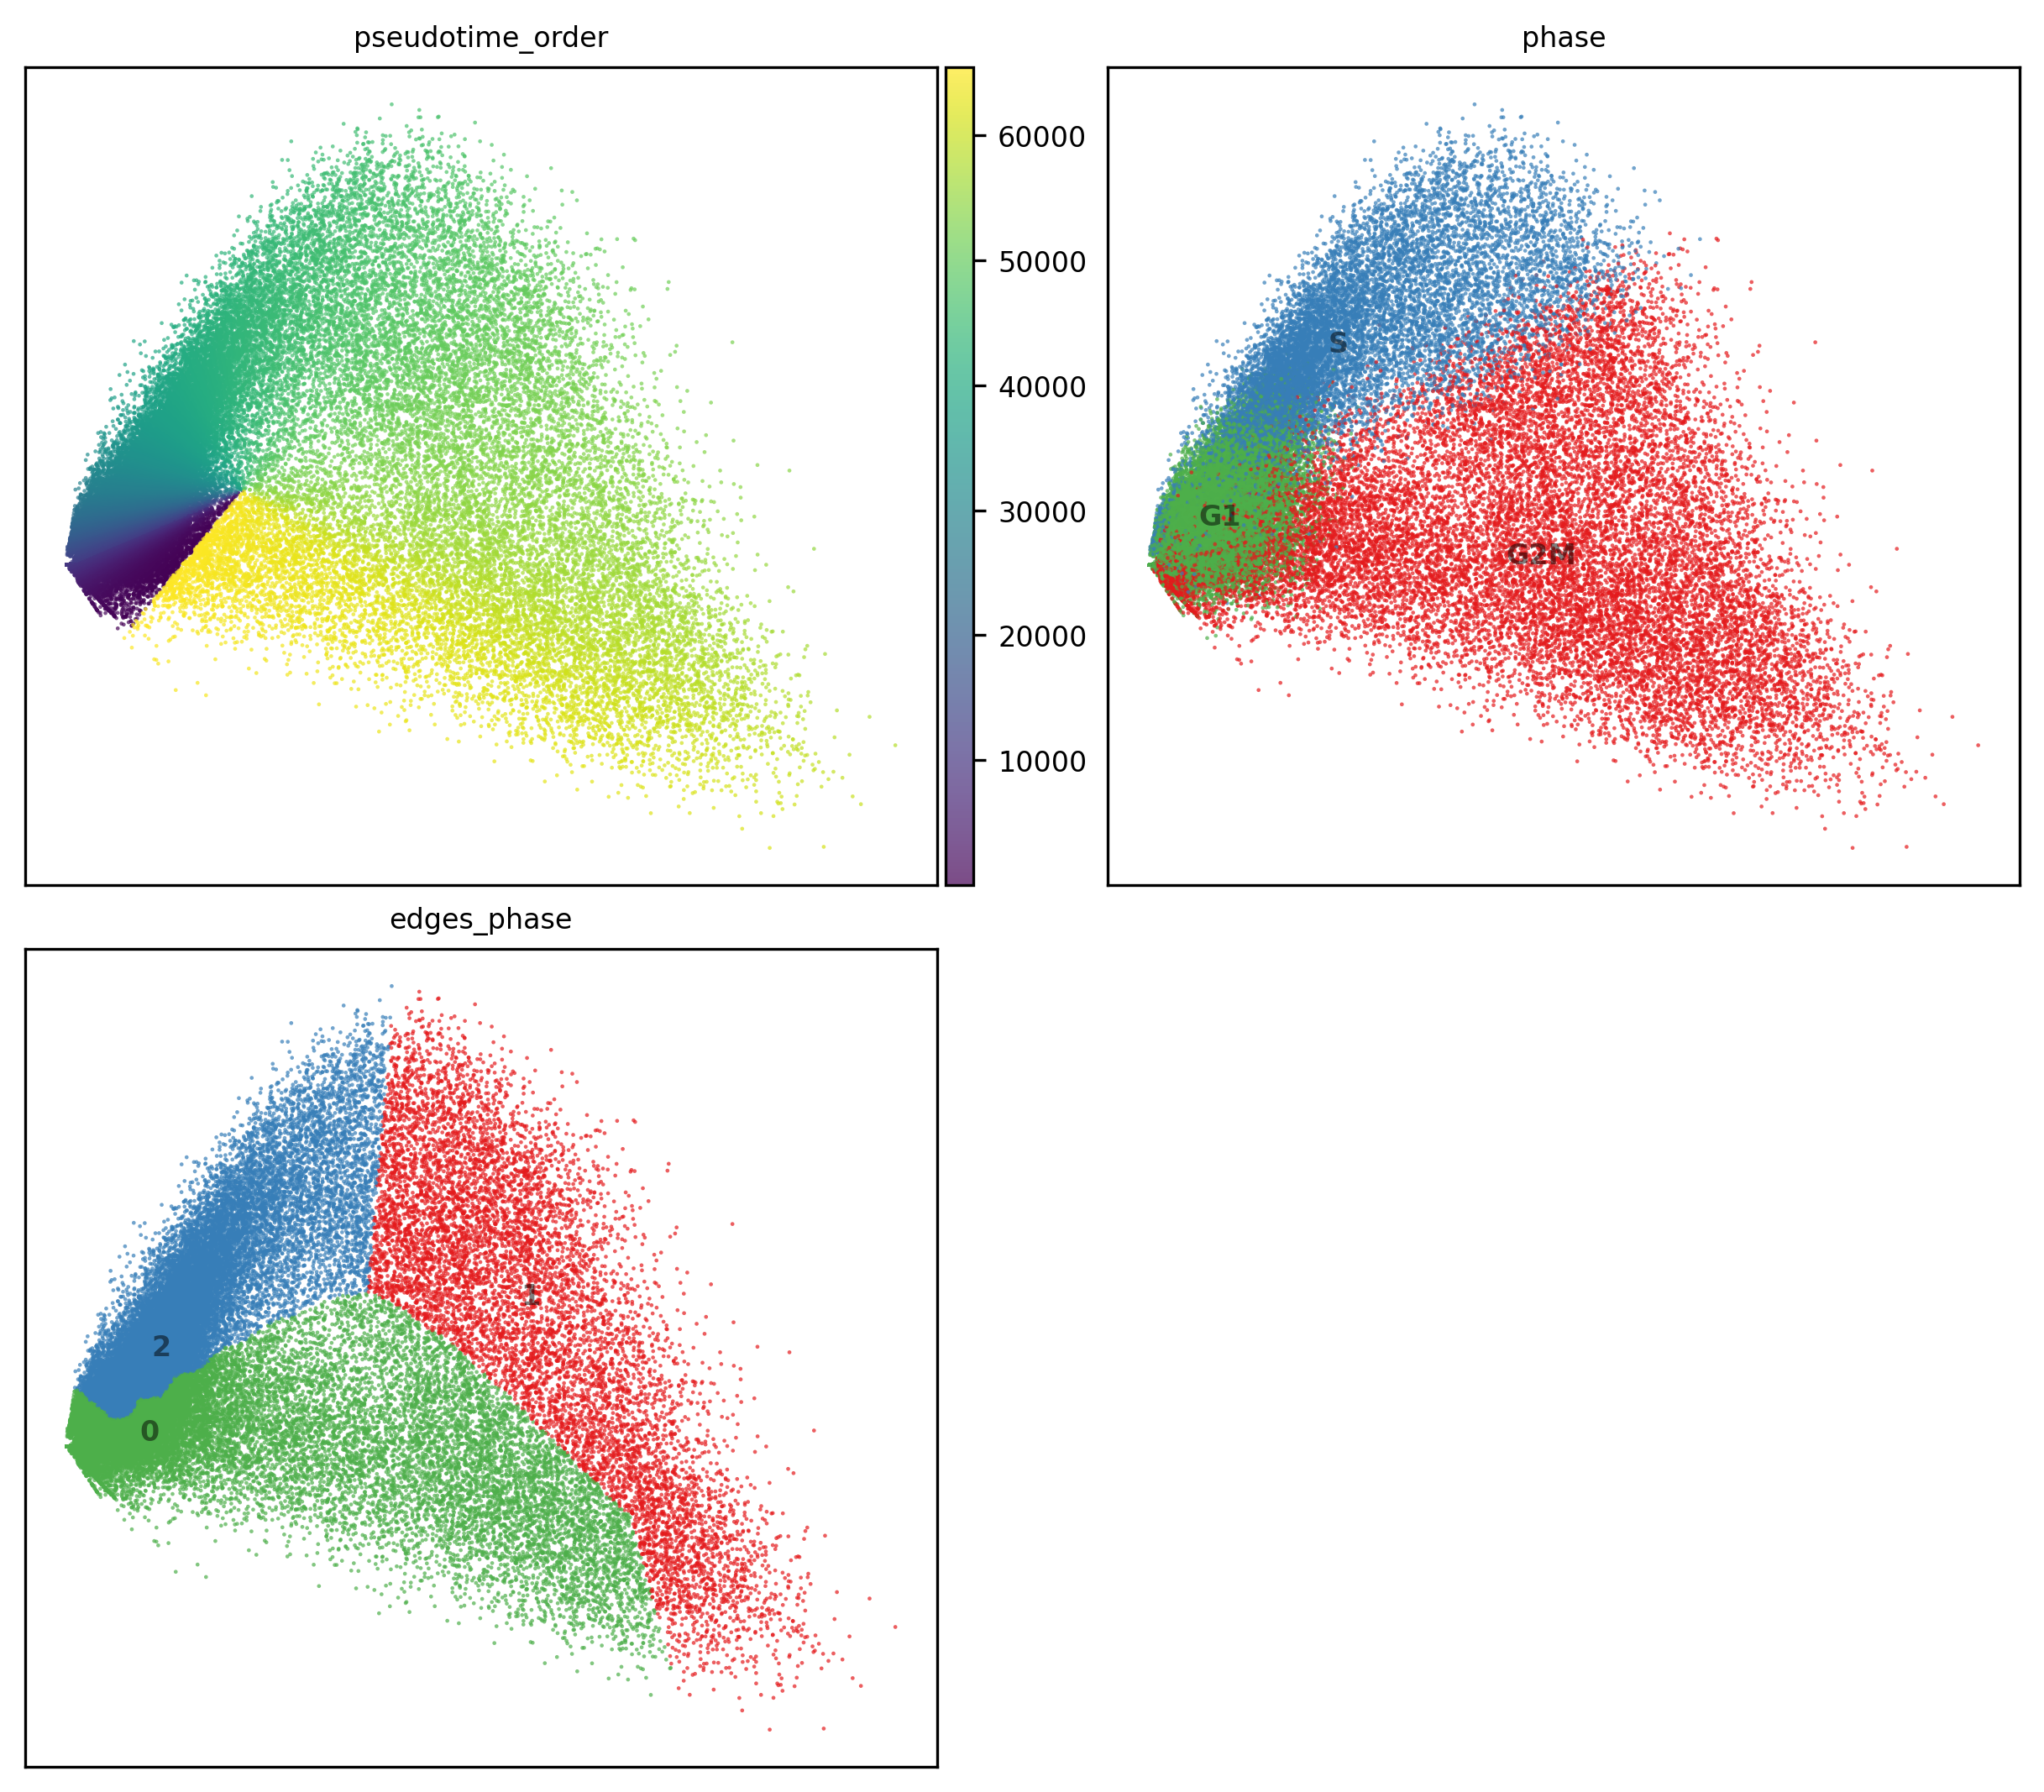

In [71]:
# color the cells by the cell cycle phase and pseudotime order (based on polar coordinates)
ccd.pl.plot_embedding(adata, color_by=['pseudotime_order','phase','edges_phase'], basis='cc_PCA', alpha=0.7,
                      point_size = 5,
                      figsize=(8, 7), ncols=2)